In [2]:
import logging
import os
from collections import defaultdict
from itertools import product
from pathlib import Path
from typing import Any, Dict, List, Tuple
from sklearn.cluster import KMeans, AgglomerativeClustering, BisectingKMeans

import IPython
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import textalloc as ta
from IPython.display import display
from scipy import stats
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier

os.chdir(path="/root/py_projects/aihiii")

from src.utils.custom_log import init_logger

LOG: logging.Logger = logging.getLogger(__name__)
import src.utils.json_util as json_util
from src._StandardNames import StandardNames
from src.utils.Csv import Csv
from src.utils.custom_log import init_logger
from src.utils.ParquetHandler import ParquetHandler
from src.utils.PathChecker import PathChecker

# from src.utils.set_rcparams import set_rcparams

init_logger(log_lvl=logging.INFO)
# set_rcparams()

STR: StandardNames = StandardNames()

PICTURE_DIR: Path = Path("reports") / "figures" / Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]).stem
PICTURE_DIR.mkdir(parents=True, exist_ok=True)
LOG.info("PICTURE_DIR: %s, Exist: %s", PICTURE_DIR, PICTURE_DIR.is_dir())

HIII_DIR: Path = PathChecker().check_directory(Path("data") / "doe" / "doe_sobol_20240705_194200")
INJ_CHSTDEFL: str = "Chest_Deflection"
CH_CHSTDEFL: str = "03CHST0000OCCUDSXD"
#PRED_DIR: Path = PathChecker().check_directory(
#    Path("experiments")
#    / "2024-09-24-09-07-30_chest_defl_binary_05HIII_injury_criteria_classes_Chest_Deflection_perc05_THRES_20_00_2_from_doe_sobol_20240705_194200_ft_channels_injury_criteria"
#)

2024-09-25 13:34:29,421     INFO  MainProcess  MainThread PICTURE_DIR: reports/figures/detect_belt_slip_5th, Exist: True
2024-09-25 13:34:29,423     INFO  MainProcess  MainThread Directory 'data/doe/doe_sobol_20240705_194200' exists


In [3]:
OUTLIER_ID: Dict[str, List[int]] = json_util.load(f_path=HIII_DIR / STR.fname_dropped_ids)

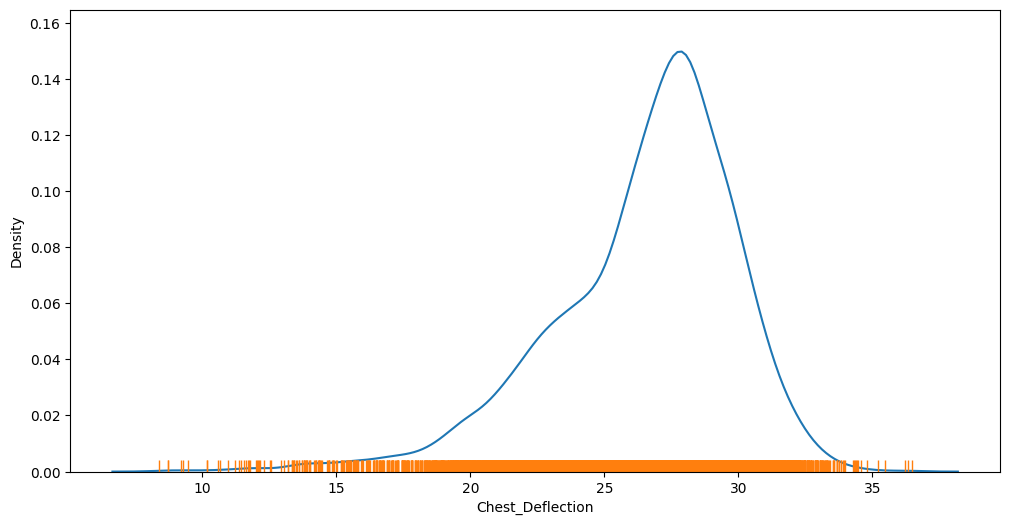

In [4]:
def plot_histogram_chest_defl(perc: int = 5):
    # get data
    db = (
        pl.scan_parquet(HIII_DIR / STR.fname_injury_crit)
        .filter(pl.col(STR.perc) == perc)
        .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
        .select([INJ_CHSTDEFL, STR.id])
        .collect()
    )

    # plot
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.kdeplot(data=db, x=INJ_CHSTDEFL, ax=ax)
    sns.rugplot(data=db, x=INJ_CHSTDEFL, ax=ax)


plot_histogram_chest_defl()

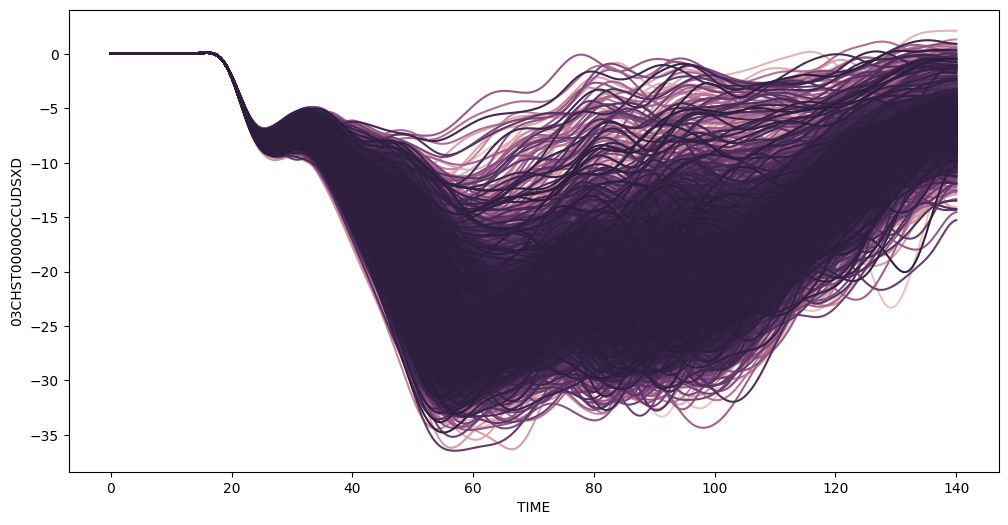

In [5]:
def plot_channel_chest_defl(perc: int = 5):
    # get data
    db = (
        pl.scan_parquet(HIII_DIR / STR.fname_channels)
        .filter(pl.col(STR.perc) == perc)
        #.filter(pl.col(STR.time).is_between(20, 40))
        .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
        .select([CH_CHSTDEFL, STR.time, STR.id])
        .collect()
    )

    # plot
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(data=db, x=STR.time, y=CH_CHSTDEFL, hue=STR.id, ax=ax, legend=False)


plot_channel_chest_defl()

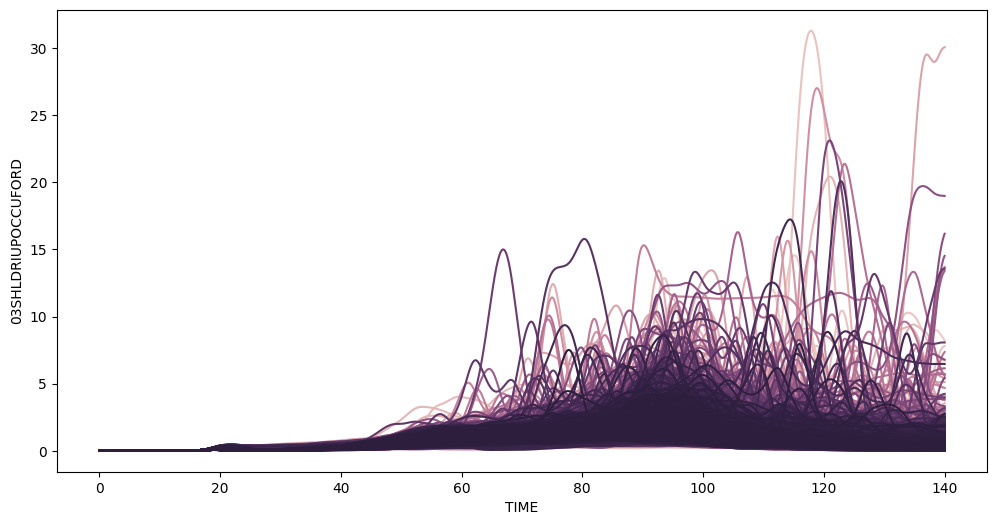

In [6]:
def plot_channel_force(perc: int = 5, channel: str = "03SHLDRIUPOCCUFORD"):
    # get data
    db = (
        pl.scan_parquet(HIII_DIR / STR.fname_channels)
        .filter(pl.col(STR.perc) == perc)
        .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
        .select([channel, STR.time, STR.id])
        .collect()
    )

    # plot
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(data=db, x=STR.time, y=channel, hue=STR.id, ax=ax, legend=False)


plot_channel_force()

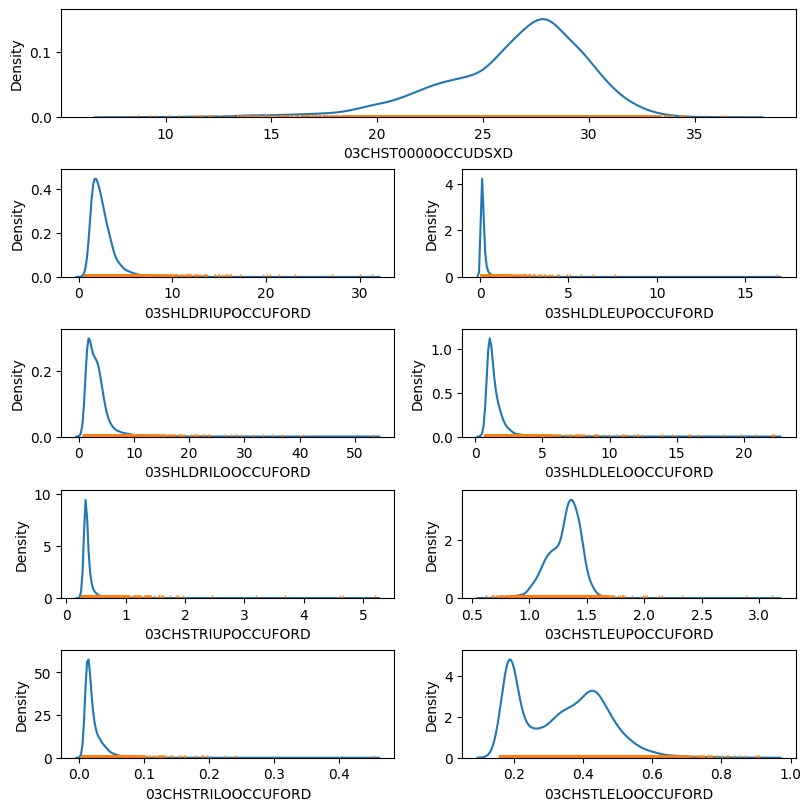

In [7]:
def plot_channel_force_max(perc: int = 5):
    chs = [
        ["03CHST0000OCCUDSXD"] * 2,
        ["03SHLDRIUPOCCUFORD", "03SHLDLEUPOCCUFORD"],
        ["03SHLDRILOOCCUFORD", "03SHLDLELOOCCUFORD"],
        ["03CHSTRIUPOCCUFORD", "03CHSTLEUPOCCUFORD"],
        ["03CHSTRILOOCCUFORD", "03CHSTLELOOCCUFORD"],
    ]
    fig, ax = plt.subplot_mosaic(mosaic=chs, figsize=(8, 8), layout="constrained")

    for ch_name in ax.keys():
        # get data
        db = (
            pl.scan_parquet(HIII_DIR / STR.fname_channels)
            .filter(pl.col(STR.perc) == perc)
            .select([pl.col(ch_name).abs(), STR.time, STR.id])
            .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
            .group_by(STR.id)
            .agg(pl.max(ch_name))
            .collect()
        )

        # plot
        sns.kdeplot(data=db, x=ch_name, ax=ax[ch_name])
        sns.rugplot(data=db, x=ch_name, ax=ax[ch_name])
        ax[ch_name].set_xlabel(ch_name)


plot_channel_force_max()

In [8]:
def get_single_max(ch_name: str, threshold: float, perc: int = 5) -> None:
    db = (
        pl.scan_parquet(HIII_DIR / STR.fname_channels)
        .filter(pl.col(STR.perc) == perc)
        .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
        .select([ch_name, STR.time, STR.id])
        .group_by(STR.id)
        .agg(pl.max(ch_name))
        .filter(pl.col(ch_name) > threshold)
        .collect()
    )

    display(db)


get_single_max("03SHLDLEUPOCCUFORD", 5)

shape: (5, 2)
┌────────┬────────────────────┐
│ ID     ┆ 03SHLDLEUPOCCUFORD │
│ ---    ┆ ---                │
│ f64    ┆ f32                │
╞════════╪════════════════════╡
│ 4690.0 ┆ 5.694455           │
│ 5857.0 ┆ 16.819147          │
│ 2691.0 ┆ 7.639882           │
│ 5496.0 ┆ 6.406173           │
│ 7230.0 ┆ 5.090809           │
└────────┴────────────────────┘

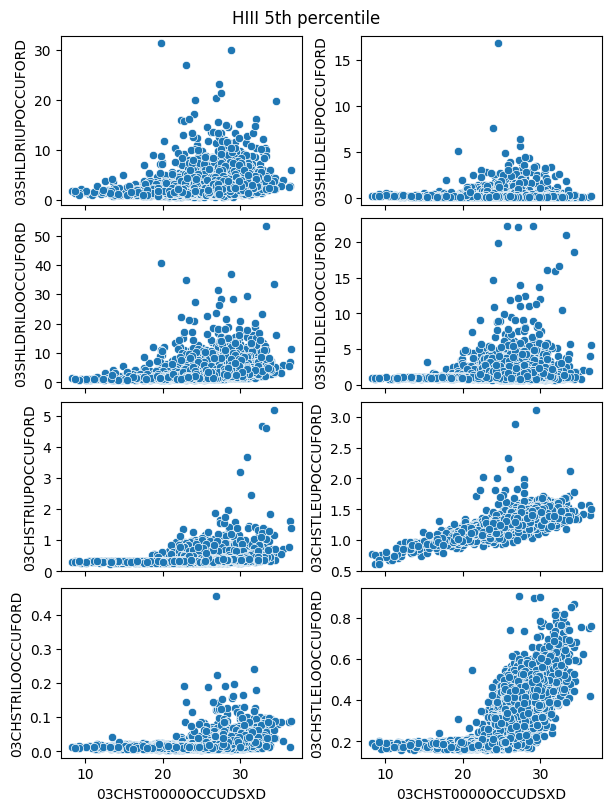

In [9]:
def crossplots(perc: int = 5):
    ref_ch_name = "03CHST0000OCCUDSXD"
    db_defl = (
        pl.scan_parquet(HIII_DIR / STR.fname_channels)
        .filter(pl.col(STR.perc) == perc)
        .select([pl.col(ref_ch_name).abs(), pl.col(STR.time), pl.col(STR.id)])
        .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
        .group_by(STR.id)
        .agg(pl.max(ref_ch_name))
        .collect()
    )

    chs = [
        ["03SHLDRIUPOCCUFORD", "03SHLDLEUPOCCUFORD"],
        ["03SHLDRILOOCCUFORD", "03SHLDLELOOCCUFORD"],
        ["03CHSTRIUPOCCUFORD", "03CHSTLEUPOCCUFORD"],
        ["03CHSTRILOOCCUFORD", "03CHSTLELOOCCUFORD"],
    ]
    fig, ax = plt.subplot_mosaic(mosaic=chs, figsize=(6, 8), layout="constrained", sharex=True)
    fig.suptitle(f"HIII {perc}th percentile")

    for ch_name in ax.keys():
        # get data
        db = (
            pl.scan_parquet(HIII_DIR / STR.fname_channels)
            .filter(pl.col(STR.perc) == perc)
            .select([ch_name, STR.time, STR.id])
            .group_by(STR.id)
            .agg(pl.max(ch_name))
            .collect()
        )

        # plot
        db = db.join(db_defl, on=STR.id)
        sns.scatterplot(data=db, x=ref_ch_name, y=ch_name, ax=ax[ch_name])


crossplots(perc=5)

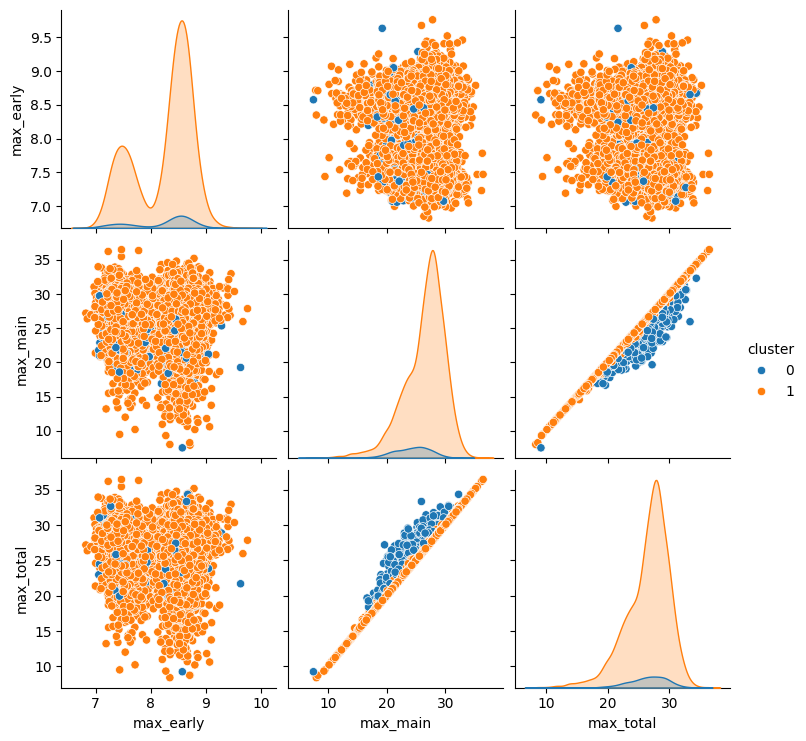

In [10]:
def some_maxis(perc=5):
    ref_ch_name = "03CHST0000OCCUDSXD"
    db = (
        pl.scan_parquet(HIII_DIR / STR.fname_channels)
        .filter(pl.col(STR.perc) == perc)
        .select([pl.col(ref_ch_name).abs(), pl.col(STR.time), pl.col(STR.id)])
        .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
        .filter(pl.col(STR.time).is_between(20, 30))
        .group_by(STR.id)
        .agg(pl.max(ref_ch_name).alias("max_early"))
        .collect()
    )
    db_defl_max_main = (
        pl.scan_parquet(HIII_DIR / STR.fname_channels)
        .filter(pl.col(STR.perc) == perc)
        .select([pl.col(ref_ch_name).abs(), pl.col(STR.time), pl.col(STR.id)])
        .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
        .filter(pl.col(STR.time).is_between(40, 80))
        .group_by(STR.id)
        .agg(pl.max(ref_ch_name).alias("max_main"))
        .collect()
    )
    db_defl_max_total = (
        pl.scan_parquet(HIII_DIR / STR.fname_channels)
        .filter(pl.col(STR.perc) == perc)
        .select([pl.col(ref_ch_name).abs(), pl.col(STR.time), pl.col(STR.id)])
        .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
        .group_by(STR.id)
        .agg(pl.max(ref_ch_name).alias("max_total"))
        .collect()
    )
    db = db.join(db_defl_max_main, on=STR.id).join(db_defl_max_total, on=STR.id).to_pandas().set_index(STR.id)

    # clustering
    #scal = RobustScaler()
    #db_ = scal.fit_transform(db)
    #cluster = KMeans(n_clusters=2)
    #cl = cluster.fit_predict(db)
    db["cluster"] = np.isclose(db["max_total"], db["max_main"], atol=1).astype(int)
    #db["cluster"] += (db["max_early"] < 8).astype(int)


    # plot
    sns.pairplot(data=db, hue="cluster")

    return [db[db["cluster"].eq(i)].index.astype(int) for i in db["cluster"].unique()]

cl_a, cl_b = some_maxis(perc=5)

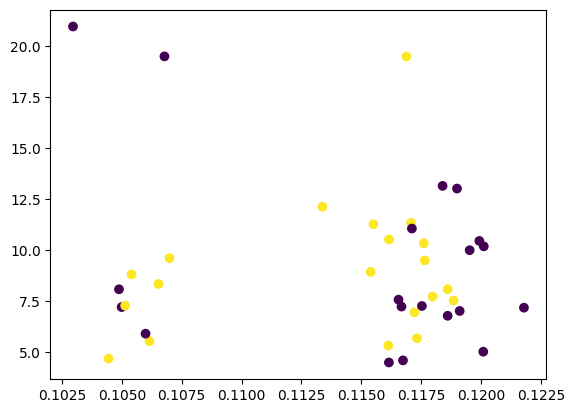

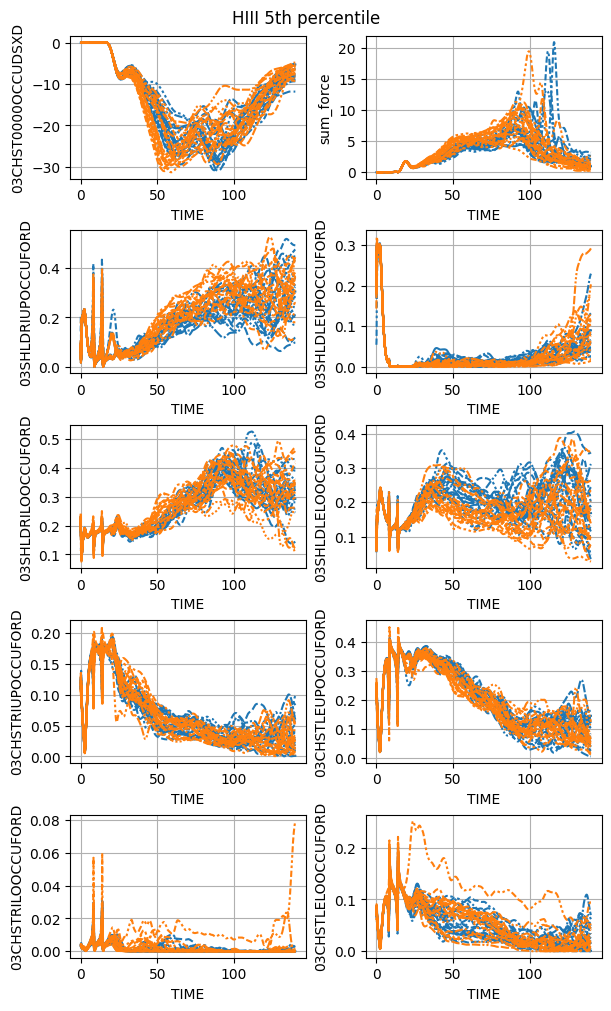

In [12]:
def plot_single_chest(sim_ids_a: List[int], sim_ids_b: List[int], perc: int = 5):
    chs = [
        ["03CHST0000OCCUDSXD", "sum_force"],
        ["03SHLDRIUPOCCUFORD", "03SHLDLEUPOCCUFORD"],
        ["03SHLDRILOOCCUFORD", "03SHLDLELOOCCUFORD"],
        ["03CHSTRIUPOCCUFORD", "03CHSTLEUPOCCUFORD"],
        ["03CHSTRILOOCCUFORD", "03CHSTLELOOCCUFORD"],
    ]
    db = (
        pl.scan_parquet(HIII_DIR / STR.fname_channels)
        .filter(pl.col(STR.perc) == perc)
        .filter(pl.col(STR.id).is_in(sim_ids_a + sim_ids_b))
        .select(*set(sum(chs[1:], [])), chs[0][0], STR.time, pl.col(STR.id).cast(pl.Int32).cast(pl.String))
        .collect()
    ).to_pandas()
    db["cluster"] = db[STR.id].isin([str(x) for x in sim_ids_a])
    db["sum_force"] = db[sum(chs[1:], [])].sum(axis=1)

    fig, ax = plt.subplots()
    db_ = db.groupby(STR.id).agg({chs[0][0]: "max", "sum_force": "max", "cluster": "first"})
    ax.scatter(db_[chs[0][0]], db_["sum_force"], c=db_["cluster"])

    fig, ax = plt.subplot_mosaic(mosaic=chs, figsize=(6, 10), layout="constrained")
    fig.suptitle(f"HIII {perc}th percentile")
    
    for ch_name in ax.keys():
        if ch_name not in chs[0]:
            db[ch_name] /= db["sum_force"]


    for ch_name in ax.keys():
        sns.lineplot(
            data=db,
            x=STR.time,
            y=ch_name,
            hue="cluster",
            style=STR.id,
            ax=ax[ch_name],
            legend=False,  # ch_name == chs[0][0],
        )
        ax[ch_name].grid()


rng = np.random.default_rng()
plot_single_chest(sim_ids_a=list(rng.choice(cl_a, 20)), sim_ids_b=list(rng.choice(cl_b, 20)))

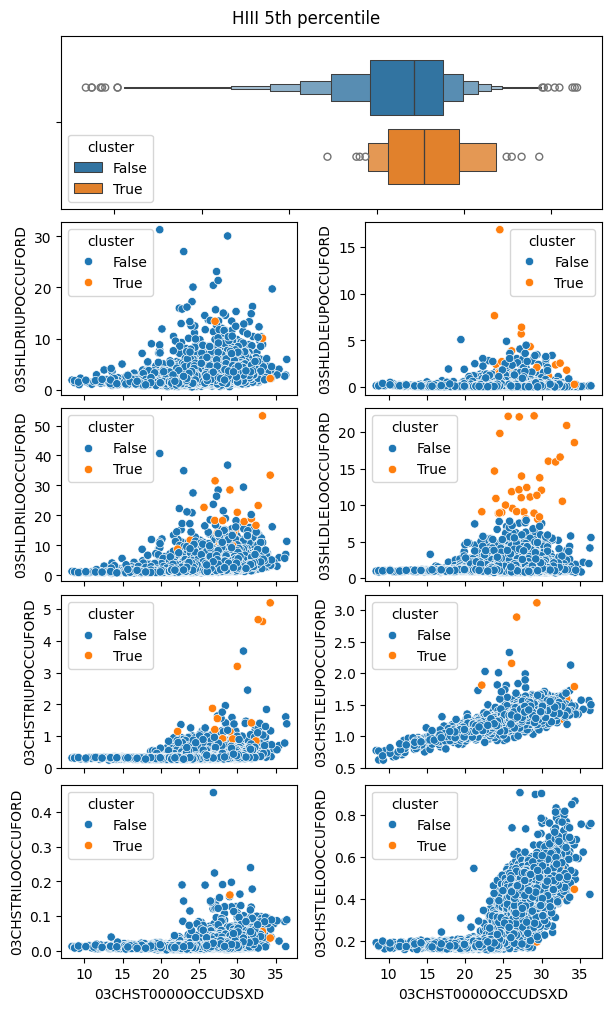

In [76]:
def crossplots_cluster(perc: int = 5):
    # channels
    ref_ch_name = "03CHST0000OCCUDSXD"
    chs = [
        ["03SHLDRIUPOCCUFORD", "03SHLDLEUPOCCUFORD"],
        ["03SHLDRILOOCCUFORD", "03SHLDLELOOCCUFORD"],
        ["03CHSTRIUPOCCUFORD", "03CHSTLEUPOCCUFORD"],
        ["03CHSTRILOOCCUFORD", "03CHSTLELOOCCUFORD"],
    ]

    # get data
    db = (
        (
            pl.scan_parquet(HIII_DIR / STR.fname_channels)
            .filter(pl.col(STR.perc) == perc)
            .select([pl.col(ref_ch_name).abs(), STR.time, STR.id, *sum(chs, [])])
            .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
            .group_by(STR.id)
            .agg(pl.max(ref_ch_name), *[pl.max(ch_name) for ch_name in sum(chs, [])])
            .collect()
        )
        .to_pandas()
        .set_index(STR.id)
    )

    # clustering
    #scal = RobustScaler()
    #db_ = scal.fit_transform(db[[ref_ch_name, *chs[-1]]])
    #cluster = BisectingKMeans(n_clusters=2)
    #cl = cluster.fit_predict(db_)
    db["cluster"] = db[chs[1][-1]].ge(8)

    # plot
    fig, ax = plt.subplot_mosaic(mosaic=[["hist"] * 2] + chs, figsize=(6, 10), layout="constrained", sharex=True)
    fig.suptitle(f"HIII {perc}th percentile")# (n Cl0 {np.sum(cl == 0)}, n Cl1 {np.sum(cl == 1)})")
    [
        sns.scatterplot(data=db, x=ref_ch_name, y=ch_name, hue="cluster", ax=ax[ch_name])
        for ch_name in ax.keys()
        if ch_name != "hist"
    ]
    sns.boxenplot(data=db, x=ref_ch_name, hue="cluster", ax=ax["hist"], gap=0.2)


crossplots_cluster(perc=5)

03SHLDRIUPOCCUFORD  03SHLDLEUPOCCUFORD  03SHLDRILOOCCUFORD  \
ID                                                                   
0.0               2.038813            0.076242            0.405674   
1.0               2.310283            0.105242            0.431473   
2.0               2.058962            0.142122            0.466215   
3.0               2.607516            0.289473            0.412786   
4.0               1.782727            0.293068            0.395533   
...                    ...                 ...                 ...   
8187.0            2.661265            0.095032            0.429906   
8188.0            3.596242            0.085809            0.441380   
8189.0            1.160790            0.194421            0.391997   
8190.0            4.441110            0.128242            0.420656   
8191.0            2.199349            0.047992            0.402964   

        03SHLDLELOOCCUFORD  03CHSTRIUPOCCUFORD  03CHSTLEUPOCCUFORD  \
ID                                                                   
0.0               0.249387            0.119811            0.347791   
1.0               0.296859            0.113852            0.344315   
2.0               0.271747            0.104756            0.323493   
3.0               0.275237            0.113012            0.344826   
4.0               0.304792            0.093891            0.361087   
...                    ...                 ...                 ...   
8187.0            0.224780            0.121139            0.311282   
8188.0            0.213769            0.098210            0.327673   
8189.0            0.292352            0.105069            0.332857   
8190.0            0.261959            0.108829            0.323337   
8191.0            0.311994            0.097788            0.338124   

        03CHSTRILOOCCUFORD  03CHSTLELOOCCUFORD  03CHST0000OCCUDSXD  
ID                                                                  
0.0               0.012287            0.112763           26.484718  
1.0               0.007960            0.097181           29.421156  
2.0               0.002583            0.061847           28.838224  
3.0               0.008557            0.096632           27.133959  
4.0               0.004579            0.091217           26.878269  
...                    ...                 ...                 ...  
8187.0            0.015218            0.122041           33.059040  
8188.0            0.006612            0.087953           27.979546  
8189.0            0.005764            0.100507           29.115763  
8190.0            0.003720            0.086363           29.028297  
8191.0            0.006289            0.079676           28.131145  

[8185 rows x 9 columns]

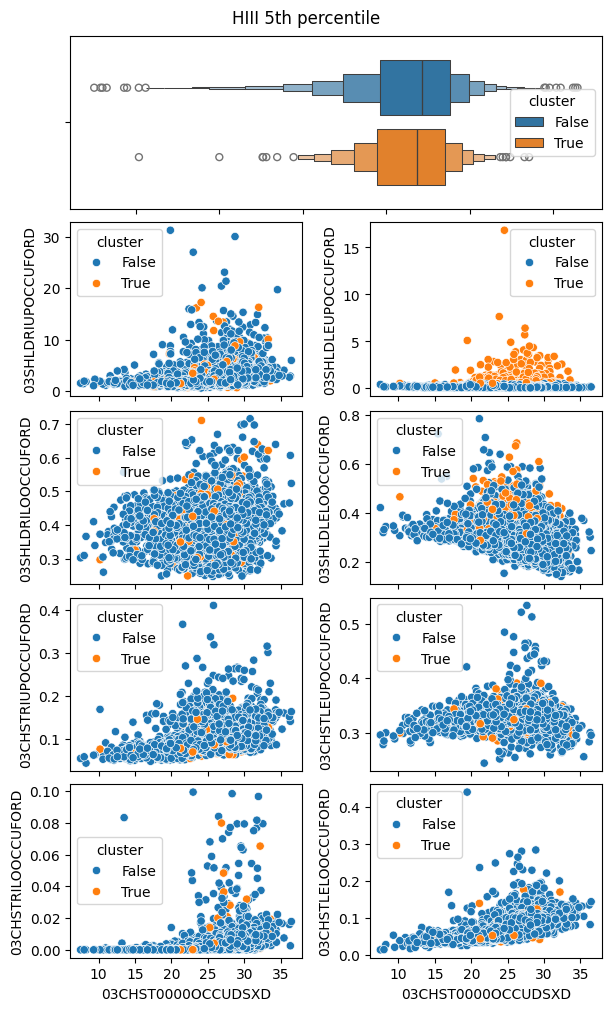

In [31]:
def crossplots_cluster2(perc: int = 5):
    # channels
    ref_ch_name = "03CHST0000OCCUDSXD"
    chs = [
        ["03SHLDRIUPOCCUFORD", "03SHLDLEUPOCCUFORD"],
        ["03SHLDRILOOCCUFORD", "03SHLDLELOOCCUFORD"],
        ["03CHSTRIUPOCCUFORD", "03CHSTLEUPOCCUFORD"],
        ["03CHSTRILOOCCUFORD", "03CHSTLELOOCCUFORD"],
    ]

    # get data
    db = (
        (
            pl.scan_parquet(HIII_DIR / STR.fname_channels)
            .filter(pl.col(STR.perc) == perc)
            .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
            .filter(pl.col(STR.time) > 40)
            .select(
                pl.sum_horizontal([pl.col(ch_name) for ch_name in sum(chs, [])]).alias("sum_force"),
                pl.col(ref_ch_name).abs(),
                STR.time,
                STR.id,
                *sum(chs, []),
            )
            .collect()
        )
        .to_pandas()
        .set_index([STR.id, STR.time])
    )

    for ch_name in sum(chs, []):
        if ch_name not in chs[0]:
            db[ch_name] /= db["sum_force"]
    db = db.groupby(STR.id).agg({ch_name: "max" for ch_name in sum(chs, []) + [ref_ch_name]})

    # clustering
    #scal = RobustScaler()
    #db_ = scal.fit_transform(db[[ref_ch_name, *chs[-1]]])
    #cluster = BisectingKMeans(n_clusters=2)
    #cl = cluster.fit_predict(db_)
    db["cluster"] = db[chs[0][-1]].ge(0.5)

    # plot
    fig, ax = plt.subplot_mosaic(mosaic=[["hist"] * 2] + chs, figsize=(6, 10), layout="constrained", sharex=True)
    fig.suptitle(f"HIII {perc}th percentile")  # (n Cl0 {np.sum(cl == 0)}, n Cl1 {np.sum(cl == 1)})")
    [
        sns.scatterplot(data=db, x=ref_ch_name, y=ch_name, hue="cluster", ax=ax[ch_name])
        for ch_name in ax.keys()
        if ch_name != "hist"
    ]
    sns.boxenplot(data=db, x=ref_ch_name, hue="cluster", ax=ax["hist"], gap=0.2)


crossplots_cluster2(perc=5)

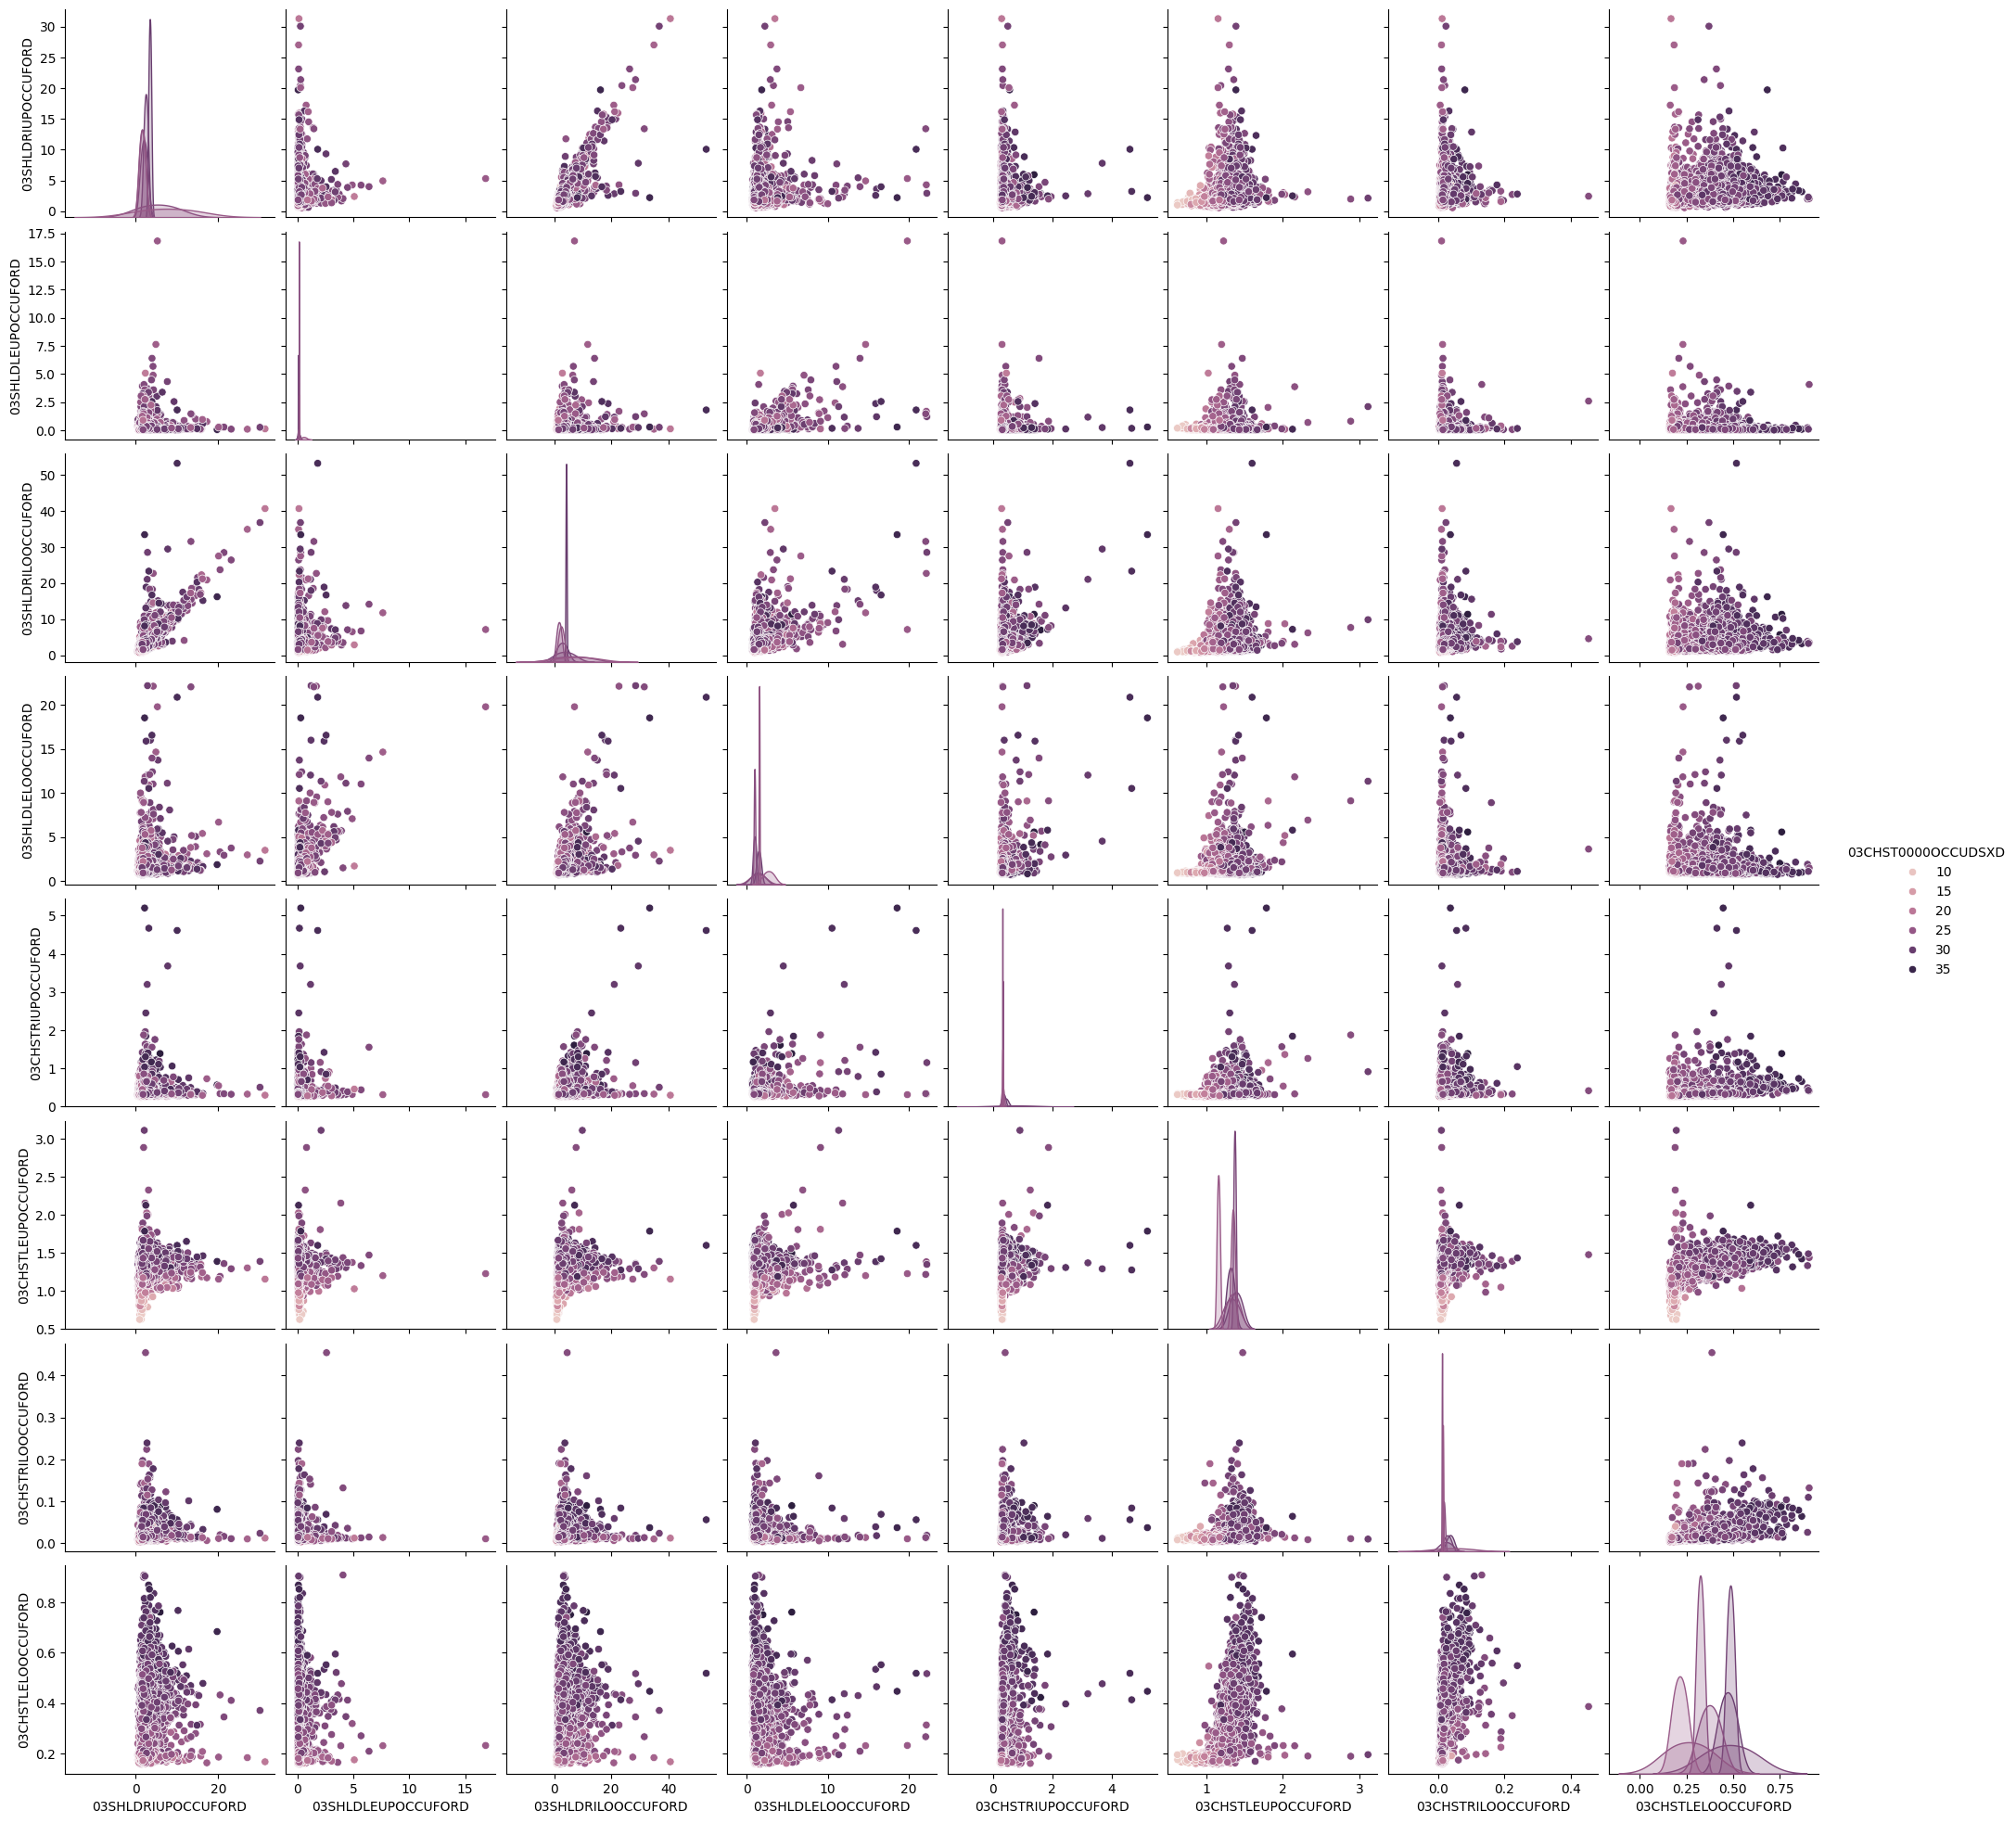

In [9]:
def crossplots_forces(perc: int = 5):
    ref_ch_name = "03CHST0000OCCUDSXD"
    db = (
        pl.scan_parquet(HIII_DIR / STR.fname_channels)
        .filter(pl.col(STR.perc) == perc)
        .select([pl.col(ref_ch_name).abs(), pl.col(STR.time), pl.col(STR.id)])
        .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
        .group_by(STR.id)
        .agg(pl.max(ref_ch_name))
        .collect()
    )

    chs = [
        "03SHLDRIUPOCCUFORD",
        "03SHLDLEUPOCCUFORD",
        "03SHLDRILOOCCUFORD",
        "03SHLDLELOOCCUFORD",
        "03CHSTRIUPOCCUFORD",
        "03CHSTLEUPOCCUFORD",
        "03CHSTRILOOCCUFORD",
        "03CHSTLELOOCCUFORD",
    ]

    for ch_name in chs:
        # plot
        db = db.join(
            (
                pl.scan_parquet(HIII_DIR / STR.fname_channels)
                .filter(pl.col(STR.perc) == perc)
                .select([ch_name, STR.time, STR.id])
                .group_by(STR.id)
                .agg(pl.max(ch_name))
                .collect()
            ),
            on=STR.id,
        )
    db = db.to_pandas()
    db.set_index(STR.id, inplace=True)
    sns.pairplot(data=db, hue=ref_ch_name)


crossplots_forces(perc=5)

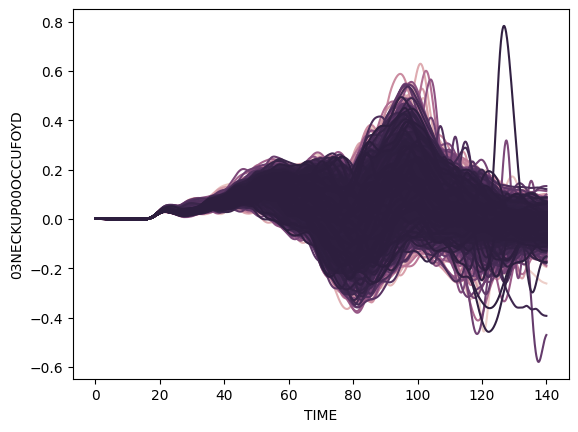

In [10]:
def get_fy_force_neck(perc: int = 5):
    col_name = "03NECKUP00OCCUFOYD"
    db = (
        pl.scan_parquet(HIII_DIR / STR.fname_channels)
        .filter(pl.col(STR.perc) == perc)
        .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
        .select([col_name, STR.time, STR.id])
        .collect()
    )

    sns.lineplot(data=db, x=STR.time, y=col_name, hue=STR.id, legend=False)


get_fy_force_neck()

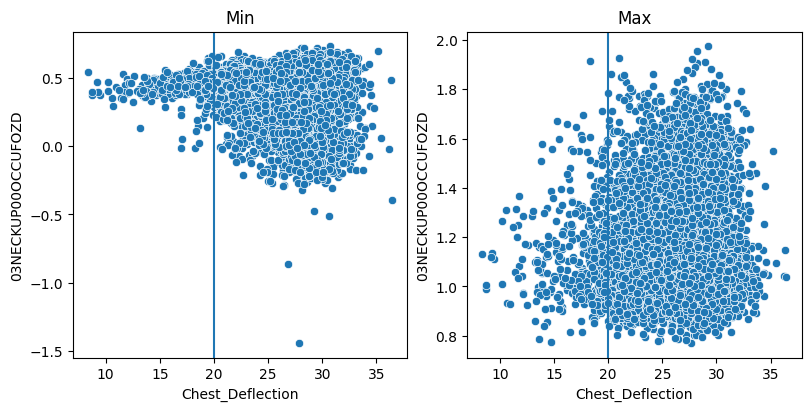

In [11]:
def neck_and_chest(perc: int = 5, col_name: str = "03NECKUP00OCCUFOZD", store: bool = False):

    db_chest = (
        pl.scan_parquet(HIII_DIR / STR.fname_injury_crit)
        .filter(pl.col(STR.perc) == perc)
        .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
        .select([INJ_CHSTDEFL, STR.id])
        .collect()
    )

    fig, ax = plt.subplot_mosaic([["Min", "Max"]], layout="constrained", figsize=(8, 4))

    for d in ax.keys():
        sns.scatterplot(
            data=db_chest.join(
                pl.scan_parquet(HIII_DIR / STR.fname_channels)
                .filter(pl.col(STR.perc) == perc)
                .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
                .filter(pl.col(STR.time).is_between(60, 100))
                .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
                .select([col_name, STR.time, STR.id])
                .group_by(STR.id)
                .agg(pl.min(col_name) if d == "Min" else pl.max(col_name))
                .collect(),
                on=STR.id,
            ),
            x=INJ_CHSTDEFL,
            y=col_name,
            ax=ax[d],
        )
        ax[d].set_title(d)
        ax[d].axvline(20)

    if store:
        plt.savefig(PICTURE_DIR / f"{INJ_CHSTDEFL}_2_{col_name}_{perc}.png")
        plt.close(fig)


neck_and_chest()

In [12]:
_ = [
    neck_and_chest(col_name=c, store=True)
    for c in pl.scan_parquet(HIII_DIR / STR.fname_channels).collect_schema().keys()
    if c.startswith("03")
]

In [13]:
def compare_chst_defl(perc: int = 5, thres: float = 4):
    db_chest_window = (
        pl.scan_parquet(HIII_DIR / STR.fname_channels)
        .filter(pl.col(STR.perc) == perc)
        .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
        .filter(pl.col(STR.time).is_between(60, 100))
        .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
        .select([CH_CHSTDEFL, STR.time, STR.id])
        .group_by(STR.id)
        .agg(pl.min(CH_CHSTDEFL))
        .collect()
    )

    db_chest_full = (
        pl.scan_parquet(HIII_DIR / STR.fname_channels)
        .filter(pl.col(STR.perc) == perc)
        .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
        .filter(~pl.col(STR.id).is_in(OUTLIER_ID[str(perc)]))
        .select([CH_CHSTDEFL, STR.time, STR.id])
        .group_by(STR.id)
        .agg(pl.min(CH_CHSTDEFL))
        .collect()
    )

    new = db_chest_full.join(db_chest_window, on=STR.id)
    new = new.select([pl.col(CH_CHSTDEFL) - pl.col(CH_CHSTDEFL + "_right"), STR.id])
    display(new.filter(~pl.col(CH_CHSTDEFL).is_between(-thres, thres)))


compare_chst_defl(thres=0.1)

shape: (3_455, 2)
┌────────────────────┬────────┐
│ 03CHST0000OCCUDSXD ┆ ID     │
│ ---                ┆ ---    │
│ f32                ┆ f64    │
╞════════════════════╪════════╡
│ -2.14323           ┆ 1294.0 │
│ -0.922615          ┆ 4969.0 │
│ -2.68161           ┆ 1942.0 │
│ -1.305849          ┆ 4265.0 │
│ -1.296543          ┆ 7798.0 │
│ …                  ┆ …      │
│ -2.291388          ┆ 6902.0 │
│ -2.158142          ┆ 7858.0 │
│ -2.722361          ┆ 6201.0 │
│ -0.950258          ┆ 491.0  │
│ -0.80698           ┆ 1325.0 │
└────────────────────┴────────┘

In [14]:
def eval_prediction():
    y_true = pd.read_parquet(PRED_DIR / "y_true_Test_Fold3.parquet")
    y_pred = pd.read_parquet(PRED_DIR / "y_pred_Test_Fold3.parquet")
    c_name = y_true.columns[0]
    print(f1_score(y_true.loc[y_true.index, c_name], y_pred.loc[y_true.index, c_name]))

    sns.heatmap(confusion_matrix(y_true.loc[y_true.index, c_name], y_pred.loc[y_true.index, c_name]), annot=True, fmt="d")


eval_prediction()

NameError: name 'PRED_DIR' is not defined

In [ ]:
def prepare_x(x: pd.DataFrame, scaler=None) -> Tuple[pd.DataFrame, RobustScaler]:
    if scaler is None:
        scaler = RobustScaler()
        x.loc[:, :] = scaler.fit_transform(x)
    else:
        x.loc[:, :] = scaler.transform(x)

    return x.unstack(STR.time).astype(np.float32), scaler


def own_prediction():
    rel_features = [
        "03HEADLOC0OCCUDSXD",
        "03HEADLOC0OCCUDSYD",
        "03HEADLOC0OCCUDSZD",
        "03HEAD0000OCCUACXD",
        "03HEAD0000OCCUACYD",
        "03HEAD0000OCCUACZD",
        "03CHSTLOC0OCCUDSXD",
        "03CHSTLOC0OCCUDSYD",
        "03CHSTLOC0OCCUDSZD",
        "03CHST0000OCCUDSXD",
        "03CHST0000OCCUACXD",
        "03CHST0000OCCUACYD",
        "03CHST0000OCCUACZD",
        "03PELVLOC0OCCUDSXD",
        "03PELVLOC0OCCUDSYD",
        "03PELVLOC0OCCUDSZD",
        "03PELV0000OCCUACXD",
        "03PELV0000OCCUACYD",
        "03PELV0000OCCUACZD",
        "03NECKUP00OCCUFOXD",
        "03NECKUP00OCCUFOZD",
        "03NECKUP00OCCUMOYD",
        "03FEMRRI00OCCUFOZD",
        "03FEMRLE00OCCUFOZD",
    ]
    ids = (
        pl.scan_parquet(HIII_DIR / STR.fname_injury_crit)
        .filter(pl.col(STR.perc) == 5)
        .select([STR.id])
        .filter(~pl.col(STR.id).is_in(OUTLIER_ID["5"] + OUTLIER_ID["50"]))
        .collect()
    )[STR.id].to_list()
    rng = np.random.default_rng(42)
    ids_train = rng.choice(ids, size=int(0.8 * len(ids)), replace=False)
    ids_test = list(set(ids) - set(ids_train))
    LOG.info("Train: %s, Test: %s", len(ids_train), len(ids_test))

    LOG.info("Prepare x_train")
    x_train, scal = prepare_x(
        (
            pl.scan_parquet(HIII_DIR / STR.fname_channels)
            .filter(pl.col(STR.id).is_in(ids_train))
            .filter(pl.col(STR.perc) == 50)
            .select(rel_features + [STR.id, STR.time])
            .collect()
            .to_pandas()
            .set_index([STR.id, STR.time])
        )
    )

    LOG.info("Prepare y_train")
    y_train = (
        pl.scan_parquet(HIII_DIR / "injury_criteria_classes_Chest_Deflection_perc05_THRES_20_00_2.parquet")
        .filter(pl.col(STR.id).is_in(ids_train))
        .select(pl.all().exclude(STR.perc))
        .collect()
        .to_pandas()
        .set_index(STR.id)
    )

    LOG.info("Train")
    model = XGBClassifier()
    model.fit(x_train.loc[y_train.index], y_train)
    y_train_pred = model.predict(x_train.loc[y_train.index])

    del x_train
    LOG.info("Score")
    sc = f1_score(y_train, y_train_pred)
    LOG.info("Score Training: %s", sc)
    del y_train_pred, y_train

    LOG.info("Prepare x_test")
    x_test, _ = prepare_x(
        (
            pl.scan_parquet(HIII_DIR / STR.fname_channels)
            .filter(pl.col(STR.id).is_in(ids_test))
            .filter(pl.col(STR.perc) == 50)
            .select(rel_features + [STR.id, STR.time])
            .collect()
            .to_pandas()
            .set_index([STR.id, STR.time])
        ),
        scaler=scal,
    )

    LOG.info("Prepare y_test")
    y_test = (
        pl.scan_parquet(HIII_DIR / "injury_criteria_classes_Chest_Deflection_perc05_THRES_20_00_2.parquet")
        .filter(pl.col(STR.id).is_in(ids_test))
        .select(pl.all().exclude(STR.perc))
        .collect()
        .to_pandas()
        .set_index(STR.id)
    )

    LOG.info("Predict")
    y_test_pred = model.predict(x_test.loc[y_test.index])
    del x_test

    LOG.info("Score")
    sc = f1_score(y_test, y_test_pred)
    LOG.info("Score Test: %s", sc)

    LOG.info("Confusion Matrix")
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d")


own_prediction()

In [ ]:
pl.scan_parquet(HIII_DIR / STR.fname_channels).select(STR.id).unique().collect()